In [1]:
#!/usr/bin/env python

import platform
import sys
import os
from time import time
from itertools import groupby

import warnings
#with warnings.catch_warnings():
#    warnings.simplefilter('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

import bs4
from bs4 import BeautifulSoup
import urllib
from urllib.request import urlopen

import re
import string
import textwrap
from textwrap import fill

import pycontractions
from pycontractions import Contractions
import autocorrect
from autocorrect import spell

import textacy
from textacy.preprocess import remove_punct

import spacy
from spacy.tokenizer import Tokenizer

import gensim
from gensim.models import Doc2Vec

import sklearn
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold

import scipy
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
#connects JS to notebook so plots work inline
init_notebook_mode(connected=True)

import cufflinks as cf
#allow offline use of cufflinks
cf.go_offline()

C:\Users\jkras\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#environment and package versions
print('\n')
print("_"*70)
print('The environment and package versions used in this script are:')
print('\n')

print(platform.platform())
print('Python', sys.version)
print('OS', os.name)
print('Numpy', np.__version__)
print('Beautiful Soup', bs4.__version__)
print('Urllib', urllib.request.__version__) 
print('Regex', re.__version__)
print('Textacy', textacy.__version__)
print('SpaCy', spacy.__version__)
print('Gensim', gensim.__version__)
print('Sklearn', sklearn.__version__)
print('Scipy', scipy.__version__)
print('Matplotlib', matplotlib.__version__)
print('Plotly', plotly.__version__)
print('Cufflinks', cf.__version__)

print('\n')
print("~"*70)
print('\n')




______________________________________________________________________
The environment and package versions used in this script are:


Windows-10-10.0.17134-SP0
Python 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
OS nt
Numpy 1.15.4
Beautiful Soup 4.6.0
Urllib 3.6
Regex 2.2.1
Textacy 0.6.2
SpaCy 2.0.12
Gensim 3.6.0
Sklearn 0.19.1
Scipy 1.0.0
Matplotlib 2.2.2
Plotly 2.2.2
Cufflinks 0.12.1


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [3]:
def get_movie_reviews(soup_broth):
    
    print('Retrieving all baseline URLs... \n')

    base_urls = [ ("https://www.imdb.com" + tag.attrs['href'], tag.text.replace('\n',' ') ) 
                            for tag in soup_broth.findAll('a', attrs={'href': re.compile("^/title/.*_tt")}) ]
    
    print('Retrieved all second-level URLs... \n')

    level_2_urls = []
    for url, title in base_urls:
        soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
        update_url = [("https://www.imdb.com" + tag.attrs['href']) 
                            for tag in soup.findAll('a', attrs={'href': re.compile("^/title/.*tt_urv")})]
        level_2_urls.append((update_url[0], title))
        
    print('Retrieved all third-level URLs... \n')

    level_3_urls = []
    for url, title in level_2_urls:
        soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
        update_url = [("https://www.imdb.com" + soup.find('a', href=re.compile("^/review/.*tt_urv"))['href'])]
        level_3_urls.append((update_url[0], title))
        
    print('Retrieved all fourth-level URLs... \n')

    level_4_urls = []
    for url, title in level_3_urls:
        soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
        update_url = [("https://www.imdb.com" + soup.find('a', href=re.compile("^/review/.*rw_urv"))['href'])]
        level_4_urls.append((update_url[0], title))
        
    print('Retrieved all fifth-level URLs... \n')

    level_5_text = []
    for url, title in level_4_urls:
        soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
        review_text = [(soup.find('div', {'class' : re.compile("^text")}).text)]
        level_5_text.append((review_text[0], title))
        
    print('All reviews retrieved! \n')

    return level_5_text

In [4]:
def clean_component(review, contract_model, stop_words, tokenizer, puncts):
    """Text Cleaner: Expand Contractions, Tokenize, Remove Stopwords, Punctuation, Lemmatize, Spell Correct, Lowercase"""
    
    rev_contract_exp = list(contract_model.expand_texts([review], precise=True))
    
    doc_tok = tokenizer(rev_contract_exp[0])

    doc_lems = [tok.lemma_ for tok in doc_tok 
                    if (tok.text not in stop_words
                        and tok.text not in puncts
                        and tok.pos_ != "PUNCT" and tok.pos_ != "SYM")]
    
    lem_list = [re.search(r'\(?([0-9A-Za-z-]+)\)?', tok).group(1) 
                    if '-' in tok 
                    else spell(remove_punct(tok)) 
                        for tok in doc_lems]

    doc2vec_input = [t.lower() for tok in lem_list 
                         for t in tok.split() 
                             if t.lower() not in stop_words]
    
    return doc2vec_input

In [5]:
def get_tagged_documents(input_review_texts, contract_model, stop_words, tokenizer, puncts, sentence_labeler):
    print('Creating Tagged Documents... \n')
    
    all_content = []
    j=0
    for rev, ttl in input_review_texts:
        print('Cleaning review #{}'.format(j+1))
        clean_rev = clean_component(rev, contract_model, stop_words, tokenizer, puncts)
        all_content.append(sentence_labeler(clean_rev, [ttl]))
        j += 1

    print('Total Number of Movie Review Document Vectors: ', j)
    
    return all_content

In [6]:
def pretty_print(input_text, ttl):
    
    format = '%s'
    pieces = [format % (word) for word in input_text]
    output = ' '.join(pieces)
    write_up = fill(output)
    print('\n')
    print('_'*70)
    print(write_up)
    print('\n')
    print(ttl)
    print('-'*70)
    
    return None

In [7]:
def get_most_similar(input_rev, all_revs, d2v_model):
    
    most_sim_tag = d2v_model.docvecs.most_similar(input_rev)[0][0]

    for rev in all_revs:
        if rev[1][0] == most_sim_tag:
            print('\n')
            print('The Review Document Most Similar to {} is: '.format(input_rev))
            pretty_print(rev[0], rev[1])
            print('Their Cosine Similarity Score is: ')
            print(d2v_model.docvecs.similarity(input_rev, rev[1][0]))
            print('_'*70)
            print('\n')
            
    return None

In [8]:
def get_most_dissimilar(input_rev, all_revs, d2v_model):
    
    sim_list = []
    for rev, ttl in all_revs:
        sim_list.append((d2v_model.docvecs.similarity(input_rev, ttl[0]), ttl[0]))

    least_sim_tag = sorted(sim_list)[0][1]

    for rev in all_revs:
        if rev[1][0] == least_sim_tag:
            print('\n')
            print('The Review Document Most Dissimilar to {} is: '.format(input_rev))
            pretty_print(rev[0], rev[1])
            print('Their Cosine Similarity Score is: ')
            print(d2v_model.docvecs.similarity(input_rev, rev[1][0]))
            print('_'*70)
            print('\n')
            
    return None

In [9]:
def doc2vec_similarity(tagged_reviews, review_type):

    d2v_model = Doc2Vec(tagged_reviews, vector_size = 5000, window = 5, 
                                                min_count = 5, workers = 8, dm = 1, 
                                                alpha=0.025, min_alpha=0.001)

    d2v_model.train(tagged_reviews, total_examples=d2v_model.corpus_count, epochs=300)

    print('According to IMDB, the Most Helpful Review on the 100 {} Horror Movies List is: '.format(review_type))

    pretty_print(tagged_reviews[0][0], tagged_reviews[0][1])

    print('Most Similar Review Documents: \n')
    print(d2v_model.docvecs.most_similar(tagged_reviews[0][1][0]))
    print('_'*70)

    get_most_similar(tagged_reviews[0][1][0], tagged_reviews, d2v_model)

    get_most_dissimilar(tagged_reviews[0][1][0], tagged_reviews, d2v_model)

    print('According to IMDB, the Least Helpful Review on the 100 {} Horror Movies List is: '.format(review_type))

    pretty_print(tagged_reviews[-1][0], tagged_reviews[-1][1])

    print('Most Similar Review Documents: \n')
    print(d2v_model.docvecs.most_similar(tagged_reviews[-1][1][0]))
    print('_'*70)

    get_most_similar(tagged_reviews[-1][1][0], tagged_reviews, d2v_model)

    get_most_dissimilar(tagged_reviews[-1][1][0], tagged_reviews, d2v_model)

    return d2v_model

In [10]:
def get_docs_closest_to_centroids(data_length, n_clust, clust_labels, centroid_input, doc_vecs, all_reviews, ttls_with_labels):
    
    all_data = [ i for i in range(data_length) ]
    n_in_clust = [len(list(group)) for key, group in groupby(sorted(clust_labels))]

    num_clusters = n_clust
    m_clusters = clust_labels

    centers = centroid_input

    closest_data = []
    for i in range(num_clusters):
        center_vec = centers[i]
        data_idx_within_i_cluster = [ idx for idx, clu_num in enumerate(m_clusters) if clu_num == i ]

        one_cluster_tf_matrix = np.zeros( (  n_in_clust[i] , centers.shape[1] ) )
        for row_num, data_idx in enumerate(data_idx_within_i_cluster):
            one_row = doc_vecs[data_idx]
            one_cluster_tf_matrix[row_num] = one_row

        center_vec = np.expand_dims(center_vec, axis=0)

        closest, _ = pairwise_distances_argmin_min(center_vec, one_cluster_tf_matrix)
        
        closest_idx_in_one_cluster_tf_matrix = closest[0]
        
        closest_data_row_num = data_idx_within_i_cluster[closest_idx_in_one_cluster_tf_matrix]
        data_id = all_data[closest_data_row_num]

        closest_data.append(data_id)

    closest_data_idxs = list(set(closest_data))

    for i in range(len(closest_data_idxs)):

        print('The Review Document most Representative of Grouping {} is: {} \n'.format(ttls_with_labels[closest_data_idxs[i]][1], 
                                                                         ttls_with_labels[closest_data_idxs[i]][0][0]))
        print('The Review Content is: \n')
        pretty_print(all_reviews[closest_data_idxs[i]][0], all_reviews[closest_data_idxs[i]][1])
        print('\n')

    return None

In [11]:
def kmeans_3D(input_d2v_model): 

    X = input_d2v_model.docvecs.vectors_docs

    #perform PCA with 3 Components
    pca = PCA(n_components=3)
    pca.fit(X)
    x_pca = pca.transform(X)

    print(np.amax(x_pca, axis=0))
    print(np.amin(x_pca, axis=0))

    np.random.seed(5)

    fig = tools.make_subplots(rows=1, cols=1,
                              print_grid=False,
                              specs=[[{'is_3d': True}]])
    scene = dict(
        camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=2.5, y=0.1, z=0.1)
        ),
        xaxis=dict(
            range=[-20, 20],
            title='PC_1',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            showticklabels=False, ticks=''
        ),
        yaxis=dict(
            range=[-20, 20],
            title='PC_2',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            showticklabels=False, ticks=''
        ),
        zaxis=dict(
            range=[-20,20],
            title='PC_3',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            showticklabels=False, ticks=''
        )
    )

    centers = [[1, 1], [-1, -1], [1, -1]]
    X = x_pca

    estimators = {'KMeans': KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=111).fit(X)
                  }
    fignum = 1
    for name, est in estimators.items():
        est.fit(X)
        labels = est.labels_

        trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
                             showlegend=False,
                             mode='markers',
                             marker=dict(
                                    color=labels.astype(np.float),
                                    line=dict(color='black', width=1)
            ))
        fig.append_trace(trace, 1, fignum)

        fignum = fignum + 1

    fig['layout'].update(height=1000, width=800,
                         margin=dict(l=10,r=10))

    fig['layout']['scene'].update(scene)
    #fig['layout']['scene2'].update(scene)
    #fig['layout']['scene3'].update(scene)
    #fig['layout']['scene4'].update(scene)
    #fig['layout']['scene5'].update(scene)


    iplot(fig)
    
    return None

In [12]:
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(labels[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return None

In [13]:
def plot_spectral_embed_agglom_clusters(dist_matrix, n_clust):
    
    X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(dist_matrix)
    
    for linkage in ('ward', 'average', 'complete'):
        clustering = AgglomerativeClustering(affinity='euclidean',
                                    compute_full_tree='auto',
                                    connectivity=None,
                                    linkage=linkage,
                                    memory=None,
                                    n_clusters=n_clust,
                                    ).fit(dist_matrix)
        t0 = time()
        clustering.fit(X_red)
        print("%s :\t%.2fs" % (linkage, time() - t0))    
        
        plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)
        
        print('Spectral Embedded Agglomerative Cluster Labels (Levels={} | {} Distance) are: \n\n {} \n'.format(n_clust,
                                                                                                           linkage,
                                                                                                           clustering.labels_))   
    return None

In [14]:
def dendro_static(dist_matrix, all_titles):

    dendro = dendrogram(
             dist_matrix, 
             labels=all_titles,
             no_plot=True,
             color_threshold=3.5,
             count_sort = "ascending"
             )

    icoord = np.array( dendro['icoord'] )
    dcoord = np.array( dendro['dcoord'] )
    color_list = np.array( dendro['color_list'] )

    plt.subplots(figsize=(35, 18))
    plt.yticks(fontsize = 20)
    plt.title("Hierachical Clustering - (Ward Distance)", fontsize=30)

    for xs, ys in zip(icoord, dcoord):
        color = plt.cm.Spectral( ys/8.0 )
        plt.plot(xs, ys, color)

    dendrogram(
             dist_matrix, 
             labels= all_titles,
             color_threshold= 3.5,
             count_sort = "ascending",
             #leaf_rotation= 85.,
             leaf_font_size= 20
             )
    
    return None

In [15]:
def dendro_interactive(dist_matrix, all_titles):

    fig = ff.create_dendrogram(dist_matrix, orientation='left', labels=all_titles)
    fig['layout'].update({'width':800, 'height':800})
    fig['layout'].update(font=dict(
            family='Old Standard TT, serif',
            size=9,
            color='black',
        ),  margin=dict(l=150,
            r=5,
            b=10,
            t=10,
            pad=4
    )          
                        )
    iplot(fig, filename='dendrogram_with_labels')
    
    return None

In [16]:
def dendro_heatmap(dist_matrix, all_titles):

    # Initialize figure by creating upper dendrogram
    figure = ff.create_dendrogram(dist_matrix, orientation='bottom', labels=all_titles)
    for i in range(len(figure['data'])):
        figure['data'][i]['yaxis'] = 'y2'

    # Create Side Dendrogram
    dendro_side = ff.create_dendrogram(dist_matrix, orientation='right')
    for i in range(len(dendro_side['data'])):
        dendro_side['data'][i]['xaxis'] = 'x2'

    # Add Side Dendrogram Data to Figure
    #https://community.plot.ly/t/heatmap-with-dendrogram-not-working/11634
    figure['data'].extend(dendro_side['data'])

    figure['layout']['yaxis']['ticktext'] = figure['layout']['xaxis']['ticktext']
    figure['layout']['yaxis']['tickvals'] = np.asarray(dendro_side['layout']['yaxis']['tickvals'])

    # Create Heatmap
    dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
    dendro_leaves = list(map(int, dendro_leaves))
    data_dist = pdist(dist_matrix)
    heat_data = squareform(data_dist)
    heat_data = heat_data[dendro_leaves,:]
    heat_data = heat_data[:,dendro_leaves]

    heatmap = [
        go.Heatmap(
            x = dendro_leaves,
            y = dendro_leaves,
            z = heat_data,
            colorscale = 'YIGnBu'#'YlGnBu'
        )
    ]

    heatmap[0]['x'] = figure['layout']['xaxis']['tickvals']
    heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']

    # Add Heatmap Data to Figure
    figure['data'].extend(heatmap)

    # Edit Layout
    figure['layout'].update({'width':1200, 'height':800,
                             'showlegend':False, 'hovermode': 'closest',
                             })
    figure['layout'].update(font=dict(
            family='Old Standard TT, serif',
            size=9,
            color='black',
        ),  margin=dict(l=5,
            r=5,
            b=150,
            t=5,
            pad=4
    ))

    # Edit xaxis
    figure['layout']['xaxis'].update({'domain': [.15, 1],
                                      'mirror': False,
                                      'showgrid': False,
                                      'showline': False,
                                      'zeroline': False,
                                      'tickangle':45,
                                      'ticks':""})
    # Edit xaxis2
    figure['layout'].update({'xaxis2': {'domain': [0, .15],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
                                       'ticks':""}})

    # Edit yaxis
    figure['layout']['yaxis'].update({'domain': [0, .85],
                                      'mirror': False,
                                      'showgrid': False,
                                      'showline': False,
                                      'zeroline': False,
                                      'showticklabels': False,
                                      'ticks': ""})
    # Edit yaxis2
    figure['layout'].update({'yaxis2':{'domain':[.825, .975],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
                                       'ticks':""}})

    # Plot!
    iplot(figure, filename='dendrogram_with_heatmap')
    
    return None

In [18]:
pwd

'C:\\Users\\jkras\\Desktop\\SMU\\Natural_Language_Processing\\HW_7'

In [17]:
nlp = spacy.load('en')
cont = Contractions('../GoogleNews-vectors-negative300.bin.gz')
cont.load_models()

#stopwords = spacy.lang.en.STOP_WORDS
#spacy.lang.en.STOP_WORDS.add("e.g.")
#nlp.vocab['the'].is_stop
nlp.Defaults.stop_words |= {"(a)", "(b)", "(c)", "etc", "etc.", "etc.)", "w/e", "(e.g.", "no?", "s", 
                           "film", "movie","0","1","2","3","4","5","6","7","8","9","10","e","f","k","n","q",
                            "de","oh","ones","miike","http","imdb", }
stopwords = list(nlp.Defaults.stop_words)

tokenizer = Tokenizer(nlp.vocab)

punctuations = string.punctuation

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument

In [577]:
#open the base URL webpage
html_page = urlopen("https://www.imdb.com/list/ls059633855/")

#instantiate beautiful soup object of the html page
soup = BeautifulSoup(html_page, 'lxml')

review_text = get_movie_reviews(soup)

In [585]:
all_good_movie_reviews = get_tagged_documents(review_text, cont, stopwords, tokenizer, punctuations, LabeledSentence1)

Creating Tagged Documents... 

Cleaning review #1
Cleaning review #2
Cleaning review #3
Cleaning review #4
Cleaning review #5
Cleaning review #6
Cleaning review #7
Cleaning review #8
Cleaning review #9
Cleaning review #10
Cleaning review #11
Cleaning review #12
Cleaning review #13
Cleaning review #14
Cleaning review #15
Cleaning review #16
Cleaning review #17
Cleaning review #18
Cleaning review #19
Cleaning review #20
Cleaning review #21
Cleaning review #22
Cleaning review #23
Cleaning review #24
Cleaning review #25
Cleaning review #26
Cleaning review #27
Cleaning review #28
Cleaning review #29
Cleaning review #30
Cleaning review #31
Cleaning review #32
Cleaning review #33
Cleaning review #34
Cleaning review #35
Cleaning review #36
Cleaning review #37
Cleaning review #38
Cleaning review #39
Cleaning review #40
Cleaning review #41
Cleaning review #42
Cleaning review #43
Cleaning review #44
Cleaning review #45
Cleaning review #46
Cleaning review #47
Cleaning review #48
Cleaning review #4

In [667]:
d2v_model_best = doc2vec_similarity(all_good_movie_reviews, 'Best')

According to IMDB, the Most Helpful Review on the 100 Best Horror Movies List is: 


______________________________________________________________________
coherent plot tell non-straightforward fashion open interpretations
leave require audience fill-in open end possibly filling-in way
require viewings considerable think sense watch wailing time
impression kind watch ponder read watch attempt people interpret
explain come different conclusion coherent underlie plot matt shift
piece puzzle attempt recreate coherent narrative piece fit
incompetence underlie story possibly intentionally possibly
fundamentally inconsistent like optical illusion escher drawing appear
describe physical object fact physical sense accordingly enjoy boil
content technically well-made cinematography acting costumes plot
sense tell deceptive way lure think plot sense matt sufficient thought
leave lingering irritate feel dissatisfaction confusion maybe
precisely point tell story purpose instill audience feel conf

In [1221]:
all_rev_text = [rev for rev, ttl in all_good_movie_reviews]

all_rev_ttls = [ttl[0] for rev, ttl in all_good_movie_reviews]

In [1222]:
numclust = 4
kmeans_model = KMeans(n_clusters=numclust, init='k-means++', max_iter=300, random_state=111)  
X = kmeans_model.fit(d2v_model_best.docvecs.vectors_docs)
kmeans_clust_labels = kmeans_model.labels_.tolist()

In [1223]:
output_list = list(zip(kmeans_clust_labels, all_rev_ttls))
print('The Groupings assigned by K-Means Clustering are: \n\n'.format(numclust))

for i in sorted(output_list):
    print(i)

The Groupings assigned by K-Means Clustering are: 


(0, '28 Weeks Later')
(0, 'A Quiet Place')
(0, 'A Tale of Two Sisters')
(0, 'Absentia')
(0, 'Alone')
(0, 'Baskin')
(0, 'Busanhaeng')
(0, 'Dans ma peau')
(0, "Don't Breathe")
(0, 'Eden Lake')
(0, 'Evil Dead')
(0, 'Grave')
(0, 'Gui si')
(0, 'Ha phraeng')
(0, 'Hush')
(0, 'It')
(0, 'It Comes at Night')
(0, 'Jigoku de naze warui')
(0, 'Kim Bok-nam salinsageonui jeonmal')
(0, 'Kokuhaku')
(0, 'Let Me In')
(0, 'Shutter')
(0, 'Sinister')
(0, 'Split')
(0, 'The Babadook')
(0, 'The Cabin in the Woods')
(0, 'The Conspiracy')
(0, "The Devil's Backbone")
(0, "The Devil's Candy")
(0, 'The House of the Devil')
(0, 'The Mist')
(0, 'The Neon Demon')
(0, 'The Witch')
(0, "Trick 'r Treat")
(1, 'A Girl Walks Home Alone at Night')
(1, 'Battle Royale')
(1, 'Dark Water')
(1, 'Otesánek')
(1, 'Taxidermia')
(1, 'Under the Shadow')
(2, 'House of 1000 Corpses')
(2, 'I Saw the Devil')
(2, 'Inside')
(2, 'Jeepers Creepers')
(2, 'Let the Right One In')
(2, 'Martyrs')

In [1224]:
ttls_and_labels_kmeans_clust =[]
i=0
for rev, ttl in all_good_movie_reviews:
    ttls_and_labels_kmeans_clust.append((ttl, kmeans_clust_labels[i]))
    i +=1

In [1225]:
kmeans_clust_centroids = np.array(kmeans_model.cluster_centers_)

In [1262]:
get_docs_closest_to_centroids(data_length=100, n_clust=4, clust_labels=kmeans_clust_labels,
                                 centroid_input=kmeans_clust_centroids, doc_vecs=d2v_model_best.docvecs.vectors_docs,
                                 all_reviews=all_good_movie_reviews, ttls_with_labels=ttls_and_labels_kmeans_clust)

The Review Document most Representative of Grouping 1 is: Battle Royale 

The Review Content is: 



______________________________________________________________________
reviewer speak viewpoints idea non-japanese westerners praise knock
base violence plot fine ignorance culture spring miss subtleties teach
japanese high school year instantly appreciate skill surprise
frankness comment sad strange reality japans modern youth japan
culture obsess youth tailor under-30 younger actually crowd example
westerner watch japanese tv surprise childish thing childish average
american junior-high student appeal japanese high-school student girls
desperately try acute attract guys adults child alike read comic
droves pop strange not-too-well-hidden undercurrent pedophilia heavily
cliquish childish incomprehensible social system young japanese boy
girl guns natural result character situation realistic mix grow
anxiety old generation rise rudeness rebellion new generation culture
value politeness 

In [1227]:
pca = PCA(n_components=2).fit(d2v_model_best.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model_best.docvecs.vectors_docs)

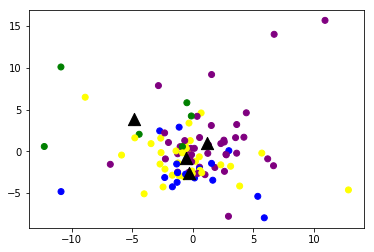

In [1231]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#ff0000"]
color = [label1[i] for i in kmeans_clust_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [1306]:
kmeans_3D(d2v_model_best)

[12.877349 15.725962 16.150534]
[-12.319181   -7.9875264 -10.509524 ]


In [1280]:
tfidf_input = [' '.join(t) for t in all_rev_text]

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.2,
                                   use_idf=True, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(tfidf_input)

In [1281]:
dist = 1 - cosine_similarity(tfidf_matrix)
linkage_matrix = ward(dist)

In [1282]:
cl = linkage_matrix
numclust = 5
hier_clust_labels = fcluster(cl, numclust, criterion='maxclust')

hier_clust_labels = hier_clust_labels - 1

output_list = list(zip(hier_clust_labels, all_rev_ttls))
print('The Levels assigned by a {}-Tiered Hierarchical Clustering are: \n\n'.format(numclust))

for i in sorted(output_list):
    print(i)

The Levels assigned by a 5-Tiered Hierarchical Clustering are: 


(0, '28 Weeks Later')
(0, 'Battle Royale')
(0, "Don't Breathe")
(0, 'I Saw the Devil')
(0, 'Inside')
(0, 'Jigoku de naze warui')
(0, 'Otesánek')
(0, 'Pitch Black')
(0, 'Split')
(0, 'Yogen')
(1, 'Busanhaeng')
(1, 'Dans ma peau')
(1, 'Grave')
(1, 'Gui si')
(1, 'Hush')
(1, 'Let Me In')
(1, 'Mientras duermes')
(1, 'Noroi')
(1, 'Saam gaang yi')
(1, 'Silent Hill')
(1, 'The Conjuring 2')
(1, 'The Crazies')
(1, 'Trollhunter')
(1, 'Tsumetai nettaigyo')
(1, "You're Next")
(1, '[Rec]')
(2, '1408')
(2, '28 Days Later...')
(2, '30 Days of Night')
(2, 'A Quiet Place')
(2, 'A Tale of Two Sisters')
(2, 'Baskin')
(2, 'Dawn of the Dead')
(2, 'Evil Dead')
(2, 'Gin gwai')
(2, 'Ginger Snaps 2: Unleashed')
(2, 'Gozu')
(2, 'Ha phraeng')
(2, 'It Follows')
(2, 'Jeepers Creepers')
(2, 'Joy Ride')
(2, 'Kairo')
(2, 'Let the Right One In')
(2, 'Reincarnation')
(2, 'Resolution')
(2, 'Shadow of the Vampire')
(2, 'Shutter')
(2, 'Sinister')
(2, 'Taxider

In [1283]:
ttls_and_labels_hier_clust =[]
i=0
for rev, ttl in all_good_movie_reviews:
    ttls_and_labels_hier_clust.append((ttl, hier_clust_labels[i]))
    i +=1

In [1284]:
hier_clust_codebook = []

for i in range(hier_clust_labels.min(), hier_clust_labels.max()+1):
    hier_clust_codebook.append(d2v_model_best.docvecs.vectors_docs[hier_clust_labels == i].mean(0))

hier_clust_centroids = np.vstack(hier_clust_codebook)

In [1285]:
get_docs_closest_to_centroids(data_length=100, n_clust=5, clust_labels=hier_clust_labels, centroid_input=hier_clust_centroids,
                              doc_vecs=d2v_model_best.docvecs.vectors_docs, all_reviews=all_good_movie_reviews, 
                              ttls_with_labels=ttls_and_labels_hier_clust)

The Review Document most Representative of Grouping 4 is: It Comes at Night 

The Review Content is: 



______________________________________________________________________
confess expect way horror start rating minute downhill question
answered leave large list plot hole end predictable boring wrong wrong
horror avoidable especially like horror wait come night


['It Comes at Night']
----------------------------------------------------------------------


The Review Document most Representative of Grouping 1 is: Busanhaeng 

The Review Content is: 



______________________________________________________________________
zombies zombies cheap outra original idea moves probably mandatory
width train play beautiful girl sucker long-haired woman short skirts
babe morality story ethic means played


['Busanhaeng']
----------------------------------------------------------------------


The Review Document most Representative of Grouping 2 is: The Ring 

The Review Content is: 



_____

ward :	0.00s
Spectral Embedded Agglomerative Cluster Labels (Levels=5 | ward Distance) are: 

 [1 0 1 2 0 4 0 2 2 0 4 0 2 0 1 0 2 2 0 2 1 4 1 0 2 0 1 3 3 0 1 3 2 2 2 0 0
 1 0 0 1 0 1 1 3 2 0 4 2 0 4 1 4 0 3 0 2 0 0 3 2 0 0 1 2 4 1 0 1 2 2 1 1 1
 2 0 2 2 4 2 2 0 1 1 1 1 0 2 1 1 2 0 0 4 1 1 3 0 3 2] 

average :	0.00s
Spectral Embedded Agglomerative Cluster Labels (Levels=5 | average Distance) are: 

 [0 4 1 1 4 2 4 1 1 4 2 4 1 1 0 4 1 1 1 1 0 2 1 4 1 4 0 3 3 4 1 3 1 1 1 4 4
 0 4 4 0 4 0 0 3 1 4 2 1 4 2 0 2 4 3 4 1 4 4 3 1 4 4 0 1 2 0 4 0 1 1 0 0 0
 1 4 1 1 2 1 1 4 0 0 0 1 4 1 0 0 1 4 4 2 0 0 3 4 3 1] 

complete :	0.00s
Spectral Embedded Agglomerative Cluster Labels (Levels=5 | complete Distance) are: 

 [4 0 2 2 0 3 0 2 2 0 3 0 2 2 0 0 2 2 2 2 2 3 2 0 2 0 0 1 1 0 2 1 2 2 2 0 0
 0 0 0 4 0 1 0 1 2 0 3 2 0 3 4 3 0 1 0 2 0 0 1 2 0 0 0 2 3 4 0 4 2 2 1 4 2
 2 0 2 2 3 2 2 0 0 4 4 2 0 2 4 4 2 0 0 3 4 4 1 0 1 2] 



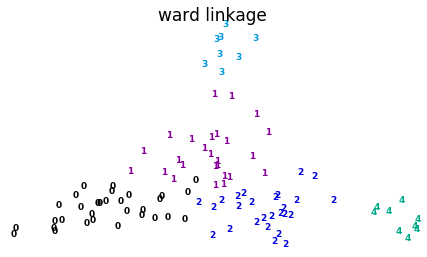

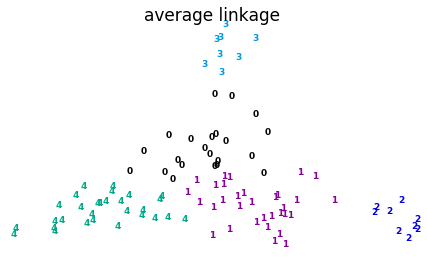

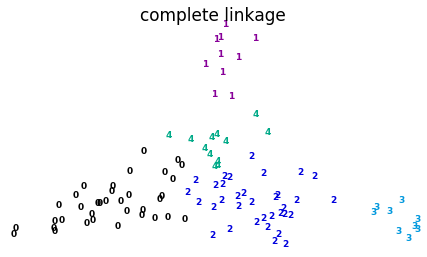

In [1238]:
plot_spectral_embed_agglom_clusters(dist, 5)

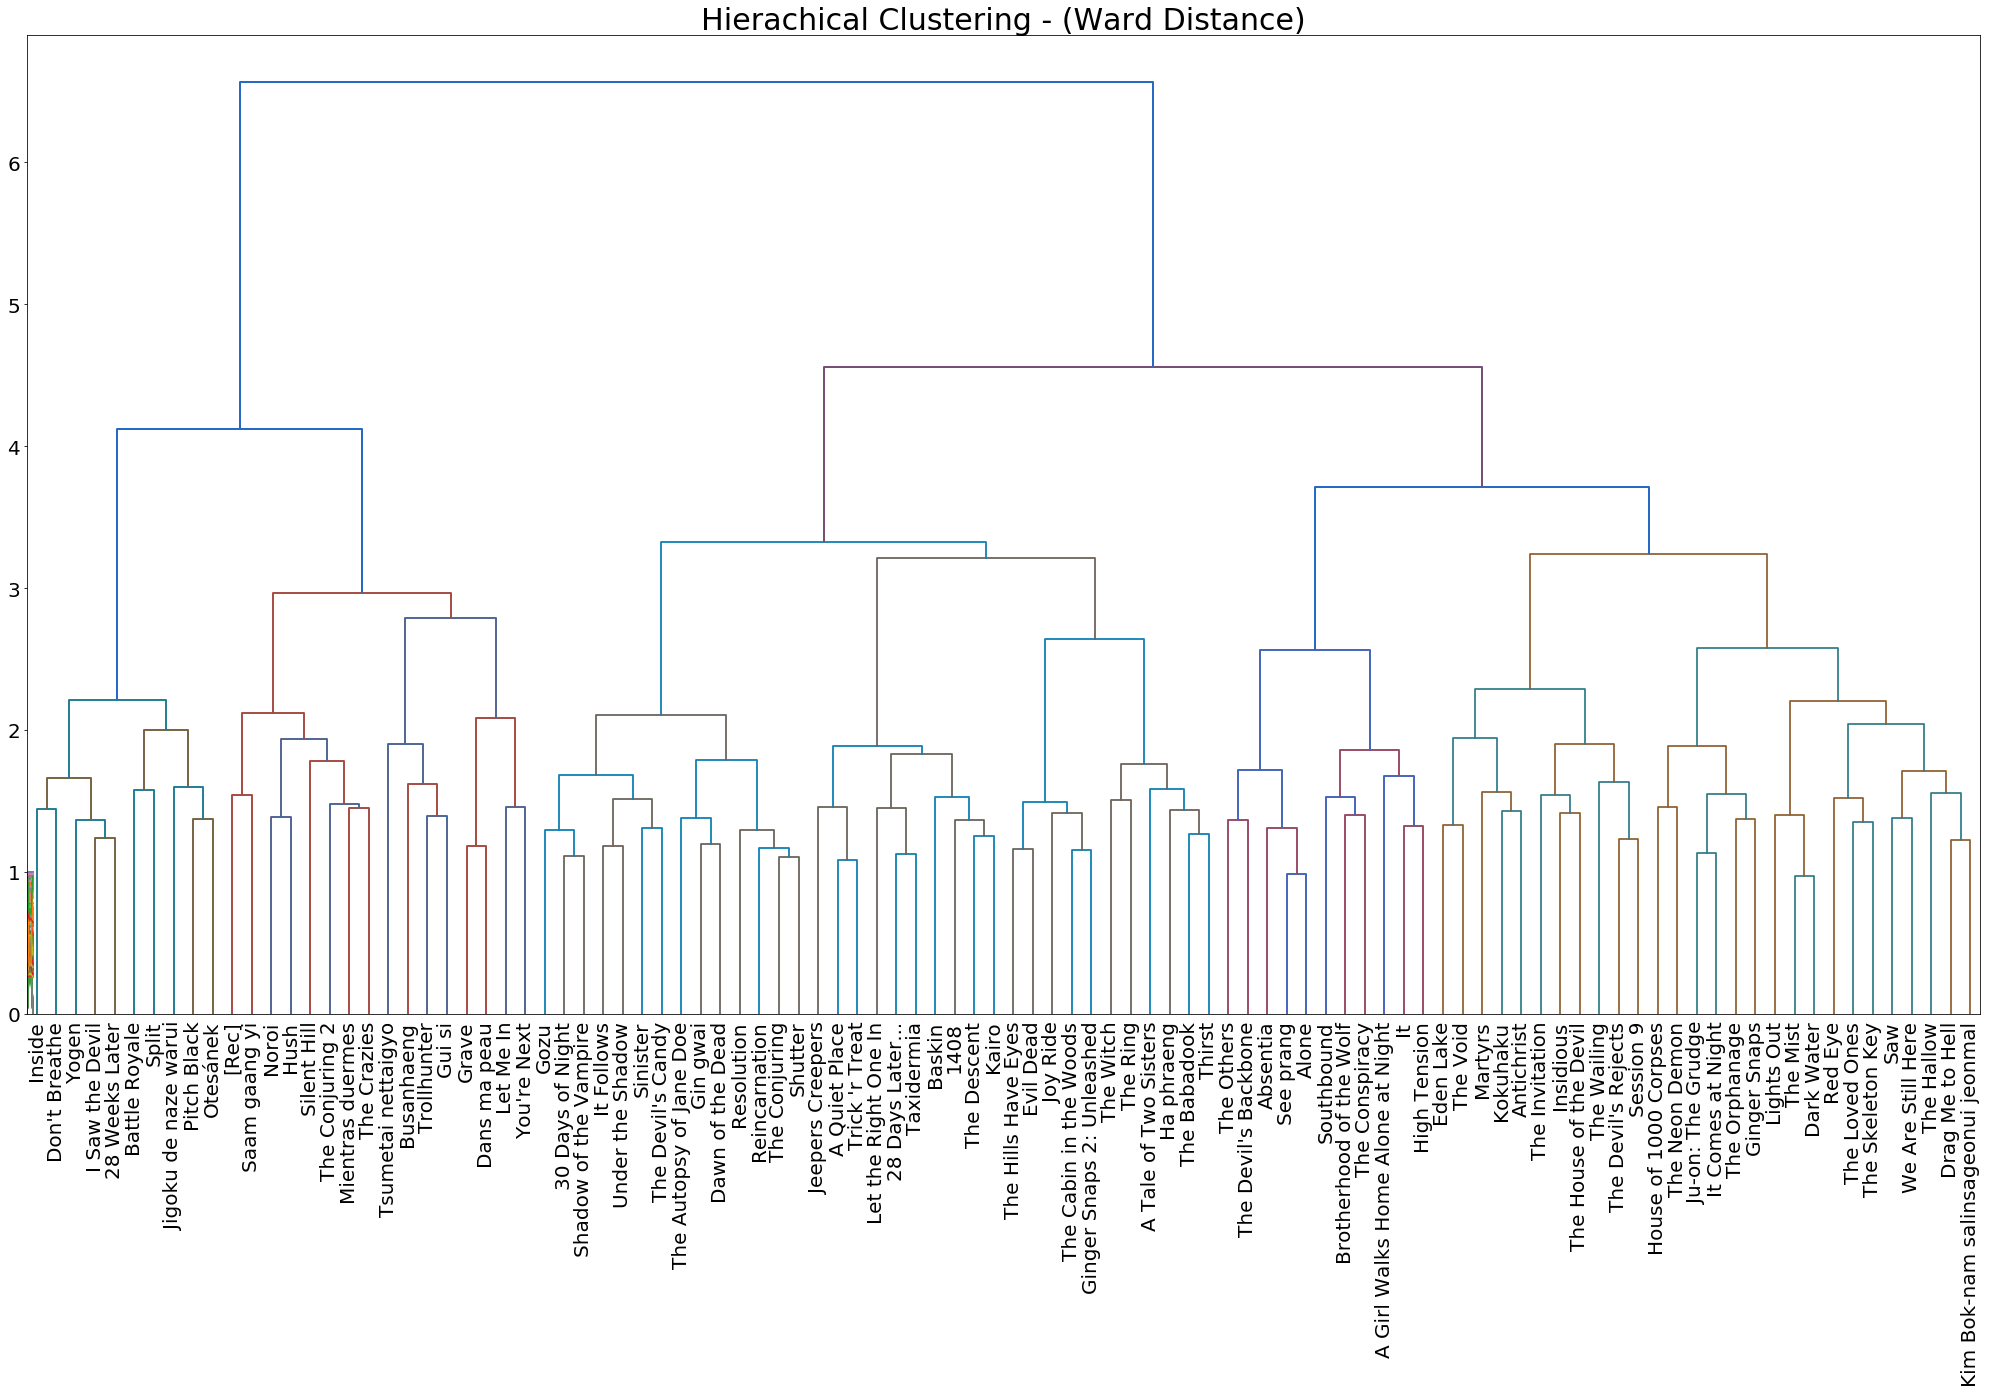

In [1239]:
dendro_static(linkage_matrix, all_rev_ttls)

In [1310]:
dendro_interactive(dist, all_rev_ttls)

In [2]:
dendro_heatmap(dist, all_rev_ttls)

NameError: name 'dist' is not defined

In [650]:
#open the base URL webpage
html_page_2 = urlopen("https://www.imdb.com/list/ls061324742/")

#instantiate beautiful soup object of the html page
soup_2 = BeautifulSoup(html_page_2, 'lxml')

review_text_2 = get_movie_reviews(soup_2)

Retrieving all baseline URLs... 

Retrieved all second-level URLs... 

Retrieved all third-level URLs... 

Retrieved all fourth-level URLs... 

Retrieved all fifth-level URLs... 

All reviews retrieved! 



In [651]:
all_bad_movie_reviews = get_tagged_documents(review_text_2, cont, stopwords, tokenizer, punctuations, LabeledSentence1)

Creating Tagged Documents... 

Cleaning review #1
Cleaning review #2
Cleaning review #3
Cleaning review #4
Cleaning review #5
Cleaning review #6
Cleaning review #7
Cleaning review #8
Cleaning review #9
Cleaning review #10
Cleaning review #11
Cleaning review #12
Cleaning review #13
Cleaning review #14
Cleaning review #15
Cleaning review #16
Cleaning review #17
Cleaning review #18
Cleaning review #19
Cleaning review #20
Cleaning review #21
Cleaning review #22
Cleaning review #23
Cleaning review #24
Cleaning review #25
Cleaning review #26
Cleaning review #27
Cleaning review #28
Cleaning review #29
Cleaning review #30
Cleaning review #31
Cleaning review #32
Cleaning review #33
Cleaning review #34
Cleaning review #35
Cleaning review #36
Cleaning review #37
Cleaning review #38
Cleaning review #39
Cleaning review #40
Cleaning review #41
Cleaning review #42
Cleaning review #43
Cleaning review #44
Cleaning review #45
Cleaning review #46
Cleaning review #47
Cleaning review #48
Cleaning review #4

In [701]:
d2v_model_worst = doc2vec_similarity(all_bad_movie_reviews, 'Worst')

According to IMDB, the Most Helpful Review on the 100 Worst Horror Movies List is: 


______________________________________________________________________
post-exorcist produce variety quirky old-fashioned horror big star
career wind happy work add touch class proceedings psychic killer jim
hutton tourist trap chuck connors shock waves john carradine peter
cushing immediately come mind manitou come 1978 thoroughly enjoy black
magic native american lore cool 1970s furnishing check tony curtis pad
-er- apartments possession stance demonic birth star trek like finish
like sum theme 1970s horror place shock truly memorable sequence
curtis bob hope approach complete quips role fake mystic suddenly
confront real things susan strasberg suitably vulnerable heroine
syrian bear michael sansara believable indian medicine man native
american 1978 bring fight evil stella stevens ann southern burgess
meredith add fun proceeding director william girdler cabby grizzly
time think long preposterous sa

In [1274]:
all_rev_text_bad = [rev for rev, ttl in all_bad_movie_reviews]

all_rev_ttls_bad = [ttl[0] for rev, ttl in all_bad_movie_reviews]

In [1275]:
numclust = 4
kmeans_model_worst = KMeans(n_clusters=numclust, init='k-means++', max_iter=300, random_state=111)  
X_worst = kmeans_model_worst.fit(d2v_model_worst.docvecs.vectors_docs)
kmeans_clust_labels_worst = kmeans_model_worst.labels_.tolist()

In [1276]:
output_list = list(zip(kmeans_clust_labels_worst, all_rev_ttls_bad))
print('The Groupings assigned by K-Means Clustering are: \n\n'.format(numclust))

for i in sorted(output_list):
    print(i)

The Groupings assigned by K-Means Clustering are: 


(0, 'Chiller')
(0, 'Friday the 13th Part VI: Jason Lives')
(0, 'Fright Night')
(0, 'Jason Goes to Hell: The Final Friday')
(0, 'My Bloody Valentine')
(0, 'Paganini Horror')
(0, 'Phenomena')
(0, 'The Hole')
(0, 'The Howling')
(0, 'The Lost Boys')
(0, 'The Texas Chainsaw Massacre 2')
(1, 'Alien 2: On Earth')
(1, 'Alligator II: The Mutation')
(1, 'Anaconda')
(1, 'Blood Beach')
(1, 'Burial Ground: The Nights of Terror')
(1, 'Cannibal Ferox')
(1, 'Cannibal Holocaust')
(1, 'Cellar Dweller')
(1, 'Critters')
(1, 'Cruel Jaws')
(1, 'Death Curse of Tartu')
(1, 'Devil Dog: The Hound of Hell')
(1, 'Eaten Alive')
(1, 'Evil Spawn')
(1, 'Funny Man')
(1, 'Halloween III: Season of the Witch')
(1, 'Haunting of Winchester House')
(1, 'Horror Hospital')
(1, 'Howling III')
(1, 'Ilsa: She Wolf of the SS')
(1, 'Interview with the Vampire: The Vampire Chronicles')
(1, 'Killer Nun')
(1, 'Monster in the Closet')
(1, 'Q')
(1, 'Shark Night 3D')
(1, 'Sleepaway Ca

In [1277]:
ttls_and_labels_kmeans_clust_bad =[]
i=0
for rev, ttl in all_bad_movie_reviews:
    ttls_and_labels_kmeans_clust_bad.append((ttl, kmeans_clust_labels_worst[i]))
    i +=1

In [1278]:
kmeans_clust_centroids_worst = np.array(kmeans_model_worst.cluster_centers_)

In [1279]:
get_docs_closest_to_centroids(data_length=100, n_clust=4, clust_labels=kmeans_clust_labels_worst,
                                 centroid_input=kmeans_clust_centroids_worst, doc_vecs=d2v_model_worst.docvecs.vectors_docs,
                                 all_reviews=all_bad_movie_reviews, ttls_with_labels=ttls_and_labels_kmeans_clust_bad)

The Review Document most Representative of Grouping 2 is: Avalanche Sharks 

The Review Content is: 



______________________________________________________________________
heaps potential wasted cute chicks thin long hair bikini contest
announced vacation grief happy intothe problem buy silly idea title
leave bride altar


['Avalanche Sharks']
----------------------------------------------------------------------


The Review Document most Representative of Grouping 0 is: The Hole 

The Review Content is: 



______________________________________________________________________
liz stumble board school bloody shake miss days tell police
psychologist party hide bunker plan friend friend martin martin return
thing turn nasty bunker martin find police tell different story slowly
true event retell flashback trailer assume teen slasher know set
britain tell think trailer example studio unsure sell product plump
low common denominators rise instead slasher horror thriller horror
twist sc

In [1248]:
pca_worst = PCA(n_components=2).fit(d2v_model_worst.docvecs.vectors_docs)
datapoint_worst = pca_worst.transform(d2v_model_worst.docvecs.vectors_docs)

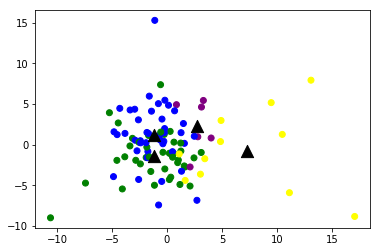

In [1249]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#ff0000"]
color = [label1[i] for i in kmeans_clust_labels_worst]
plt.scatter(datapoint_worst[:, 0], datapoint_worst[:, 1], c=color)

centroids = kmeans_model_worst.cluster_centers_
centroidpoint = pca_worst.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [1250]:
kmeans_3D(d2v_model_worst)

[17.092928 15.266196 10.863692]
[-10.582034  -8.993399  -8.859998]


In [1251]:
tfidf_input_bad = [' '.join(t) for t in all_rev_text_bad]

In [1252]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.2,
                                   use_idf=True, ngram_range=(1,3))

tfidf_matrix_bad = tfidf_vectorizer.fit_transform(tfidf_input_bad)

dist_bad = 1 - cosine_similarity(tfidf_matrix_bad)
linkage_matrix_bad = ward(dist_bad)

In [1270]:
cl = linkage_matrix_bad
numclust = 5
hier_clust_labels_bad = fcluster(cl, numclust, criterion='maxclust')

hier_clust_labels_bad = hier_clust_labels_bad - 1

output_list = list(zip(hier_clust_labels_bad, all_rev_ttls_bad))
print('The Levels assigned by a {}-Tiered Hierarchical Clustering are: \n\n'.format(numclust))

for i in sorted(output_list):
    print(i)
print('\n')

The Levels assigned by a 5-Tiered Hierarchical Clustering are: 


(0, 'Avalanche Sharks')
(0, 'Bermuda Tentacles')
(0, 'Cruel Jaws')
(0, 'Death Curse of Tartu')
(0, 'Dracula')
(0, 'Dust Devil')
(0, 'Faceless')
(0, 'Frankenstein Island')
(0, 'Grizzly II: The Concert')
(0, 'Halloween III: Season of the Witch')
(0, 'Horror of the Blood Monsters')
(0, 'Monster in the Closet')
(0, 'Piranha II: The Spawning')
(0, 'Snow Beast')
(0, 'The Fog')
(1, 'Abominable')
(1, 'Blood Beach')
(1, 'Burial Ground: The Nights of Terror')
(1, 'Cannibal Ferox')
(1, 'Critters')
(1, 'Evils of the Night')
(1, 'Funny Man')
(1, 'Haunting of Winchester House')
(1, 'Howling III')
(1, 'Prom Night')
(1, 'Sleepaway Camp')
(1, 'Subspecies')
(1, 'The House by the Cemetery')
(1, 'Tintorera: Killer Shark')
(1, 'Wolf Creek')
(2, 'A Bucket of Blood')
(2, 'Cat People')
(2, 'Chiller')
(2, 'Curse III: Blood Sacrifice')
(2, 'Death Smiles on a Murderer')
(2, 'Eaten Alive')
(2, 'From Dusk Till Dawn')
(2, 'House II: The Second Story'

In [1271]:
ttls_and_labels_hier_clust_bad =[]
i=0
for rev, ttl in all_bad_movie_reviews:
    ttls_and_labels_hier_clust_bad.append((ttl, hier_clust_labels_bad[i]))
    i +=1

In [1272]:
hier_clust_codebook_bad = []

for i in range(hier_clust_labels_bad.min(), hier_clust_labels_bad.max()+1):
    hier_clust_codebook_bad.append(d2v_model_worst.docvecs.vectors_docs[hier_clust_labels_bad == i].mean(0))

hier_clust_centroids_bad = np.vstack(hier_clust_codebook_bad)

In [1273]:
get_docs_closest_to_centroids(data_length=100, n_clust=5, clust_labels=hier_clust_labels_bad, 
                              centroid_input=hier_clust_centroids_bad,
                              doc_vecs=d2v_model_worst.docvecs.vectors_docs, all_reviews=all_bad_movie_reviews, 
                              ttls_with_labels=ttls_and_labels_hier_clust_bad)

The Review Document most Representative of Grouping 1 is: Evils of the Night 

The Review Content is: 



______________________________________________________________________
evils night involve extraterrestrial woman otina louise julie newmark
hire couple idiot rednecks kidnap kill teens use blood prolong race
like theater fortuitous accident release 1986 print just-released
nightmare elm street fail arrived theater owner evils place friend
laugh way delight familiar face cast think julie newmark like enjoy
follow career grade-b stars kick obscure piece low-budget gore horror
schlock


['Evils of the Night']
----------------------------------------------------------------------


The Review Document most Representative of Grouping 4 is: The Asphyx 

The Review Content is: 



______________________________________________________________________
rare small great plot decent special effect time good acting horror
fan require gore shock value enjoy real treaty minor flaw look closely


ward :	0.00s
Spectral Embedded Agglomerative Cluster Labels (Levels=5 | ward Distance) are: 

 [0 1 0 0 4 1 3 0 4 4 4 2 1 4 4 0 4 0 0 0 0 0 4 0 0 1 2 0 4 0 3 2 0 0 0 0 4
 4 0 1 0 1 0 3 0 0 3 3 1 0 4 0 1 0 0 4 4 3 3 4 2 3 0 0 3 2 3 0 0 0 0 1 1 1
 0 0 0 3 0 4 3 4 1 3 4 3 4 1 3 2 3 2 4 0 3 0 3 0 4 0] 

average :	0.00s
Spectral Embedded Agglomerative Cluster Labels (Levels=5 | average Distance) are: 

 [2 1 0 0 0 1 2 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 1 3 0 0 0 2 3 0 0 0 0 0
 0 0 1 0 1 0 2 0 0 2 2 1 0 0 0 1 0 0 0 0 2 2 0 3 2 0 0 2 3 2 0 0 0 0 1 4 1
 0 0 0 2 2 0 2 0 1 2 0 2 0 1 2 3 2 3 0 0 2 0 2 0 0 0] 

complete :	0.00s
Spectral Embedded Agglomerative Cluster Labels (Levels=5 | complete Distance) are: 

 [0 1 3 3 4 1 0 3 3 4 4 2 1 3 4 3 4 3 3 3 3 3 4 3 3 1 2 3 4 0 0 2 3 3 3 3 4
 4 3 1 3 1 3 0 3 3 0 0 1 3 4 3 1 3 3 4 4 0 0 4 2 0 3 3 0 2 0 3 3 3 3 1 1 1
 3 3 3 0 0 3 0 4 1 0 3 0 4 1 0 2 0 2 3 3 0 3 0 3 4 3] 



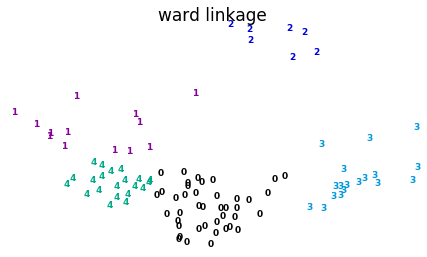

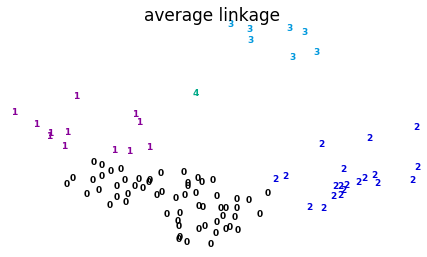

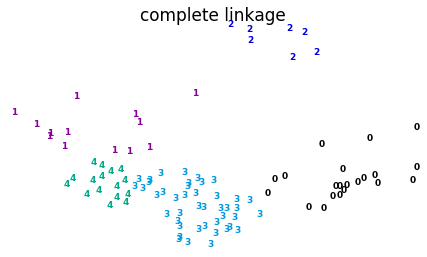

In [1257]:
plot_spectral_embed_agglom_clusters(dist_bad, n_clust=5)

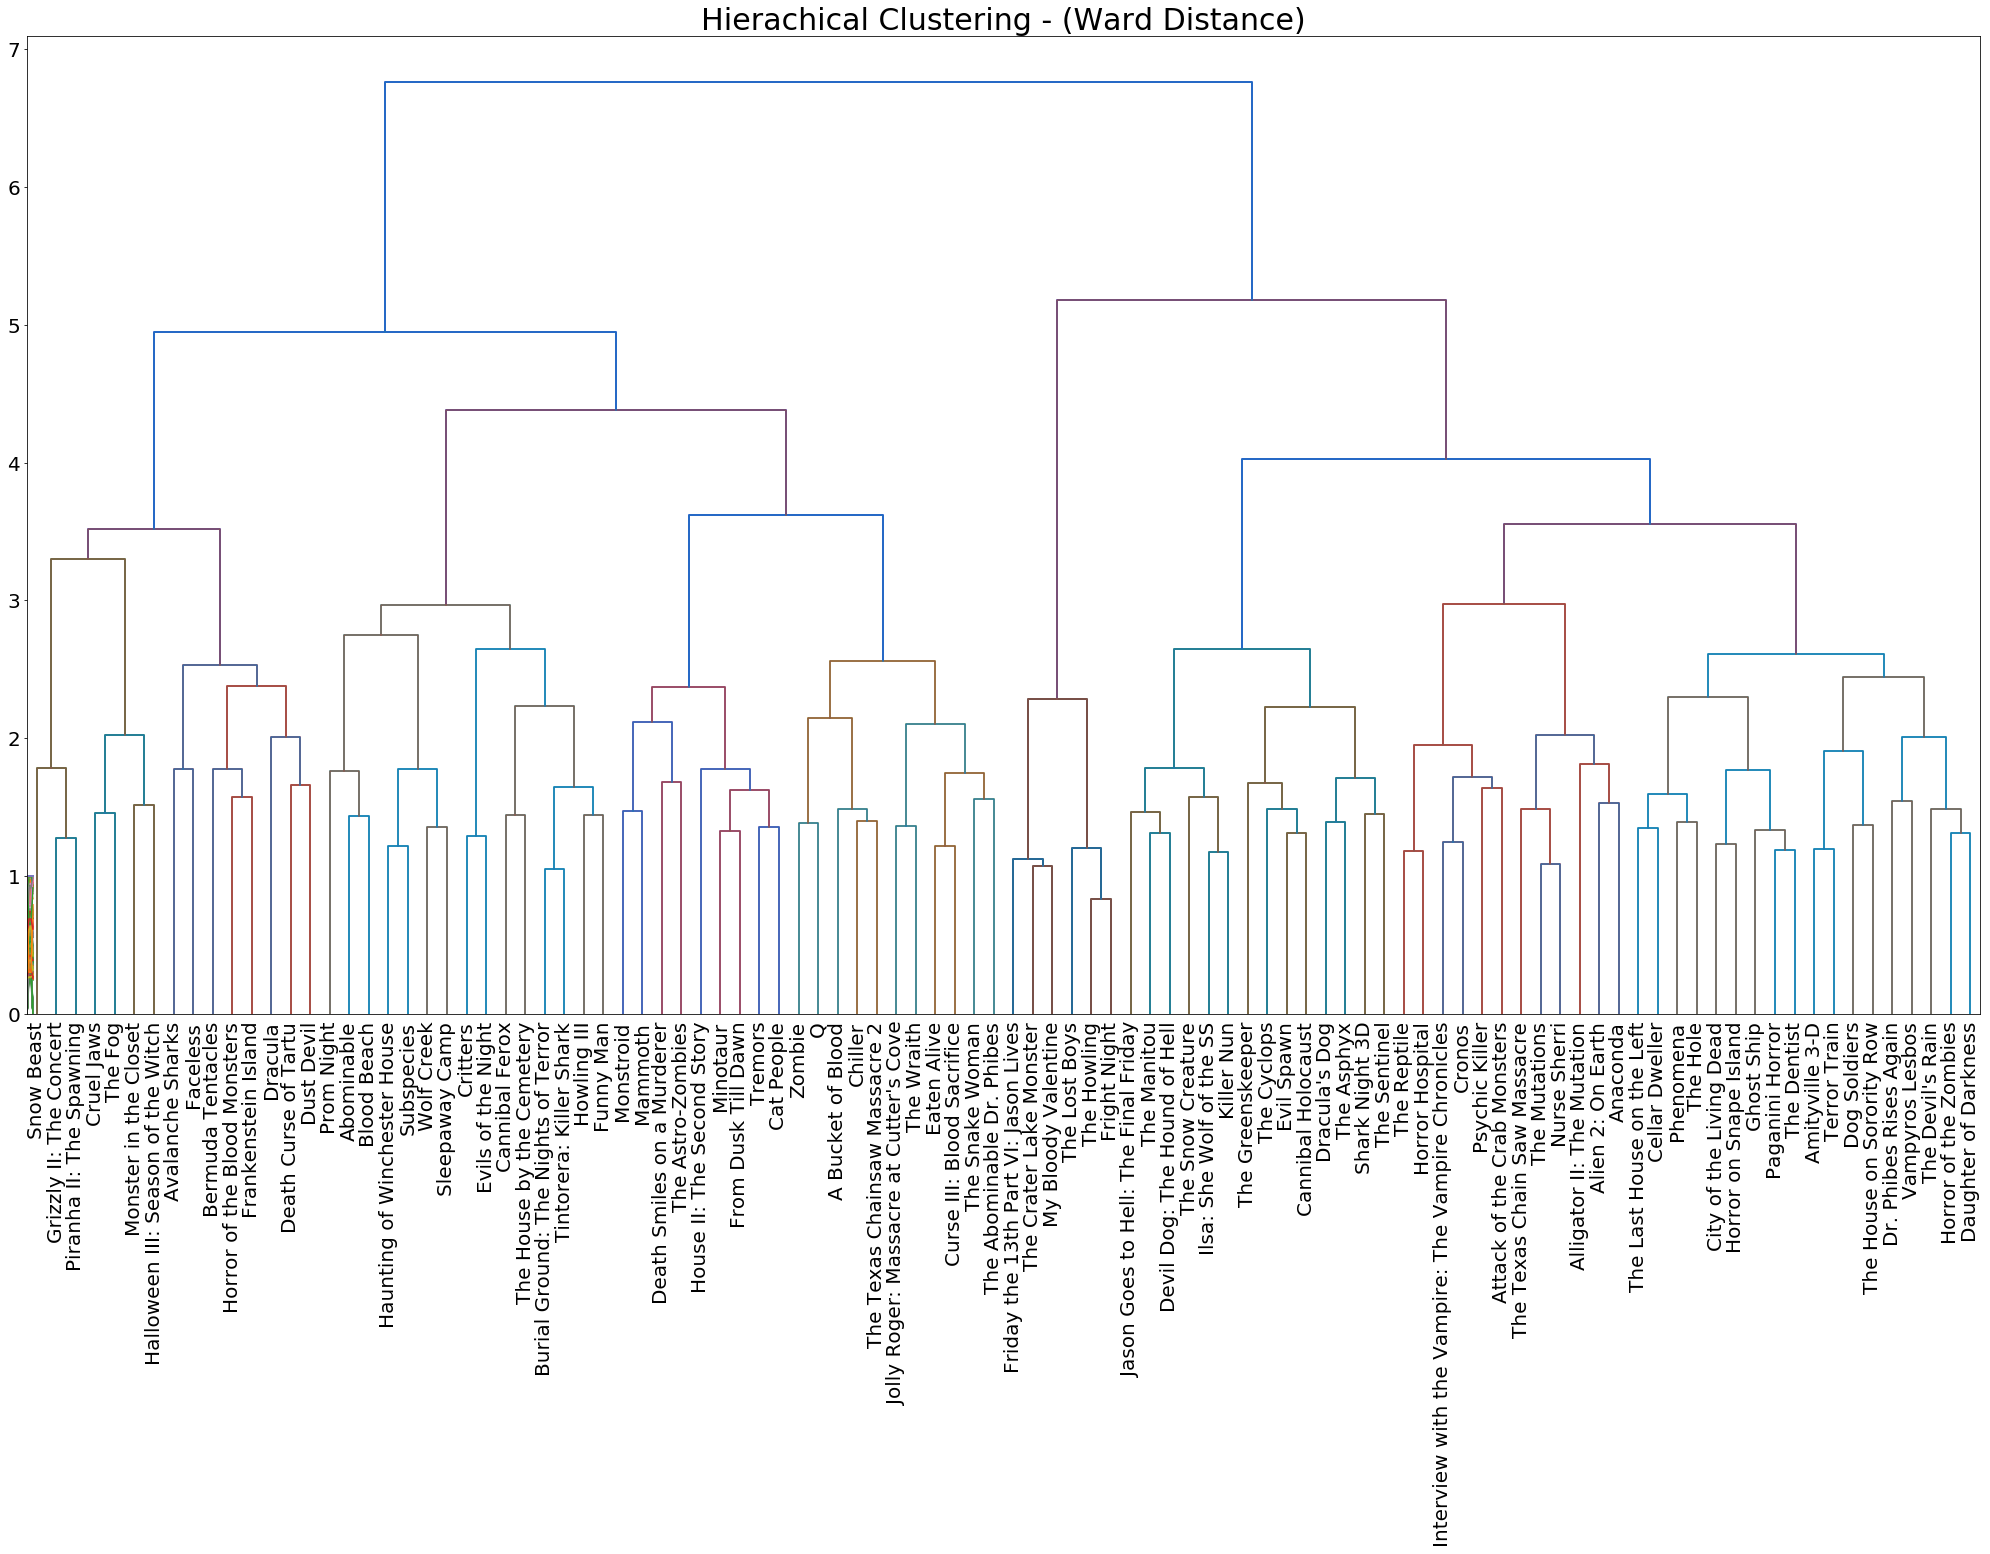

In [1258]:
dendro_static(linkage_matrix_bad, all_rev_ttls_bad)

In [1259]:
dendro_interactive(dist_bad, all_rev_ttls_bad)

In [1260]:
dendro_heatmap(dist_bad, all_rev_ttls_bad)